In [0]:
#!pip install tpot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn import svm #SVM
from sklearn.linear_model import LogisticRegression #逻辑回归
from sklearn.tree import DecisionTreeClassifier #决策树
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB #高斯朴素贝叶斯 GaussianNB/MultinomialNB/BernoulliNB
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.ensemble import  AdaBoostClassifier #AdaBoost
from xgboost import XGBClassifier #XGBoost
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
# 使用TPOT自动机器学习工具对MNIST进行分类
from tpot import TPOTClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

New features: fact-based guesses

In [0]:
# original data imported
Rate_train = pd.read_csv("train.csv")
Rate_test = pd.read_csv("test.csv")
Full_data = Rate_train.append(Rate_test)
Full_data = Full_data.drop(["EmployeeNumber", "EmployeeCount", "Over18", "StandardHours"],axis=1)
Full_data = pd.get_dummies(Full_data,dummy_na=True)
Full_data = Full_data.drop(['Attrition_No', 'Attrition_nan','BusinessTravel_nan','EducationField_nan','Department_nan','Gender_nan','JobRole_nan','MaritalStatus_nan','OverTime_nan'],axis=1)
train_clean = Full_data.iloc[:1175,:]
#train_clean.info()
test_clean = Full_data.iloc[1175:,:]
test_clean = test_clean.drop(['Attrition_Yes'],axis=1)
#test_clean.info()

The original train data has rank =  47
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 1469
Columns: 263 entries, 0 to user_id
dtypes: float64(263)
memory usage: 5.9 MB


/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


After feature engineering, the rank of train data has rank =  0


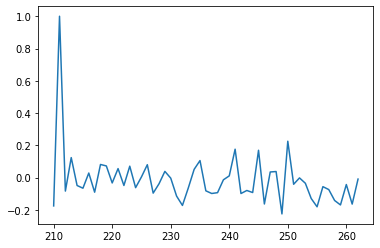

In [143]:
## Full_data expanded -- creating new features:
#first, choose the most related features to be the basis
A = train_clean.corr()
#From A we can see the following features are the most related
#'Age','JobInvolvement','JobLevel','MonthlyIncome','StockOptionLevel','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsWithCurrManage','BusinessTravel_Travel_Frequently','JobRole_Laboratory Technician','JobRole_Sales Representative','MaritalStatus_Single','OverTime_Yes'

#find the target vector for correlation check (Notice that only target in train_clean is useful)
vec = train_clean['Attrition_Yes'].to_numpy()
#print(vec)

#Now, choose the most related features in Full_data
fe_tc_df = Full_data[['Age','JobInvolvement','JobLevel','MonthlyIncome','StockOptionLevel','TotalWorkingYears','YearsAtCompany','YearsInCurrentRole','YearsWithCurrManager','BusinessTravel_Travel_Frequently','JobRole_Laboratory Technician','JobRole_Sales Representative','MaritalStatus_Single','OverTime_Yes']]
fe_tc_np = fe_tc_df.to_numpy()
#print(fe_tc_np)

#-- this is a matrix_rank check --#
tc0 = train_clean.to_numpy()
print('The original train data has rank = ',np.linalg.matrix_rank(tc0))

#iterating and multiplying with each two cols using numpy
fe_tc_np = np.array(fe_tc_np)
ftn_copy = fe_tc_np.copy()
ftn_copy = ftn_copy.T
for col1 in ftn_copy:
  for col2 in ftn_copy:
    mul = col1 * col2
    if np.isnan(mul.any()) == 1:
      continue
    else:
      mul = np.array([mul])
      fe_tc_np = np.append(fe_tc_np, mul.T, axis=1)
  np.delete(ftn_copy,col1)
  np.delete(fe_tc_np,col1)
#adding the new features to Full_data
ftn = pd.DataFrame(fe_tc_np)
Full_new = pd.concat([Full_data,ftn])
Full_new.info()#增加了210多个新feature
#print(Full_new.isnull().values.any())
train_new = Full_new.iloc[:1175,:]
test_new = Full_new.iloc[1175:,:]

#now, see the corr 
B = train_new.corr()
plt.plot(range(263),B['Attrition_Yes'])#看看新增的features相关与否

#-- this is a matrix_rank check --#
tc1 = train_new.to_numpy()
print('After feature engineering, the rank of train data has rank = ',np.linalg.matrix_rank(tc1))#？？？

In [0]:
#Next, GDBT
#and then try gdbt again
Y = train_new['Attrition_Yes']
X = train_new.drop(['Attrition_Yes'],axis=1)
# split data，25% is used to test，the rest is used to train
train_x, test_x, train_y, test_y = train_test_split( X, Y, test_size=0.25, random_state=33 )
train_x = train_x.astype( np.float )
test_x = test_x.astype( np.float )
train_y = train_y.astype( np.float )
test_y = test_y.astype( np.float )

'''
# using Z-Score regularization
ss = preprocessing.StandardScaler()
train_ss_x = ss.fit_transform( train_x )
test_ss_x = ss.transform( test_x )
# import test_new
test_ss_test = ss.transform( test_new )'''
train_ss_x = train_x
if np.isnan(train_ss_x.any().any()) == 1:
  print('train_x has Nan value')

if np.isnan(train_y.any().any()) == 1:
  print('train_y has Nan value')
test_ss_x = test_x
if np.isnan(test_ss_x.any().any()) == 1:
  print('test_x has Nan value')
test_ss_test = test_new
if np.isnan(test_ss_test.any().any()) == 1:
  print('test_new has Nan value')


In [144]:
# creating gdbt classifier -- the best result
clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01,max_depth=4,min_samples_split=2,loss='ls')
clf.fit( train_ss_x, train_y )
predict_y_gdbt = clf.predict( test_ss_x )##-- A Comparison Test --##
#print( 'SVM accuracy rate: %0.4lf' % accuracy_score( test_y, predict_y ) )
scoretemp = roc_auc_score(test_y,predict_y_gdbt)
print(scoretemp)


ValueError: ignored

In [0]:
#apply the model on the test_new data
predict_test = clf.predict( test_ss_test )# 0 and 1
pre_test = []
for i in abs(predict_test):
  if i >= 3e-1:
    i = 1
  else:
    i = 0
  pre_test.append(i)
print(pre_test)

In [0]:
#Something is wrong, please do not run#
#有问题，请勿运行#
#iterate multiply with the cols using pandas
for (columnName1, columnData1) in temp.iteritems():
  a_vec = columnData1
  for (columnName2, columnData2) in temp.iteritems():
    b_vec = columnData2
    mul_vec = pd.DataFrame(a_vec * b_vec)
    #print(mul_vec)
    NameNew = columnName1 + columnName2
    cor_mul = abs(mul_vec.corrwith(vec,axis=0))
    cor_a = abs(np.corrcoef(a_vec, vec))
    cor_b = abs(np.corrcoef(b_vec, vec))
    #if  cor_mul >= max(cor_a,cor_b):    
    temp[NameNew] = temp.add(mul_vec)
  temp = temp.drop(columnName1,axis=1)

In [0]:
A_new = train_clean.corr()
vec_new = pd.DataFrame(A['Attrition_Yes'])

In [0]:
a = pd.DataFrame([1,2,3])
b = pd.DataFrame([4,5,6])
c = a * b
c.corrwith(a,axis=0)

0    0.996616
dtype: float64

FM FFM

In [0]:
!pip install xlearn


In [0]:
train_clean.to_csv(r'train_clean.txt', header=None, index=None, sep=' ', mode='a')
test_clean.to_csv(r'test_clean.txt', header=None, index=None, sep=' ', mode='a')

In [0]:
import xlearn as xl
# 创建FFM模型
ffm_model = xl.create_ffm()
# 设置训练集和测试集
ffm_model.setTrain('train_clean.txt')
ffm_model.setValidate('teat_clean.txt')
# 设置参数，任务为二分类，学习率0.2，正则项lambda: 0.002，评估指标 accuracy
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'metric':'acc'}
?? ffm_model.fit

In [0]:
# FFM训练，并输出模型
ffm_model.fit(param, "./model.out")

In [0]:
# 设置测试集，将输出结果转换为0-1
ffm_model.setTest("test.txt")
ffm_model.setSigmoid()
ffm_model.predict("model.out", "output.txt")

Deep learning